In [1]:
from collections import OrderedDict
import pandas as pd
import numpy as np
from scipy.optimize import linprog

In [2]:
from typing import NamedTuple, Optional 

class MQI(NamedTuple):
    TC: float
    TN: float
    TP: float
    TK: float
    
    @property
    def CN_ratio(self):
        return self.TC / self.TN
    

In [3]:
MQIs = {"cow": MQI(TC=320000, TN=18000, TP=8000, TK=21000),
        "chicken": MQI(TC=250000, TN=30000, TP=18000, TK=28000),
        "soy": MQI(TC=360000, TN=60000, TP=12000, TK=25000)
       }

In [4]:
class Range(NamedTuple):
    min: Optional[float]
    max: Optional[float]

RecomendedValues = {
    "Bacteria Density": Range(2.0, None),
    "TC": Range(12000, None),
    "TN": Range(1000, None),
    "TP": Range(1100, None),
    "TK": Range(2500, 10000),
    "C/N": Range(8, 27),
    "C/P": Range(7, 25),
    "N-activity": Range(25, None),
    "P-activity": Range(20, 80)
}

PERKG2PER10A = 10 * 5000 * 4.5

max_manure_amount = 5000 / PERKG2PER10A

RecomendedValues["Amount Manure(kg)"] = Range(None, max_manure_amount)

max_organic_amount = 500 / PERKG2PER10A

RecomendedValues["Amount Organic(kg)"] = Range(None, max_organic_amount)

In [68]:
MQI_raw = {
     "cow manure": {"TC": 320000, "TN": 18000, "TP": 8000, "TK": 21000, "C/N": 17.8, "Fermented": True},
     "chicken manure": {"TC": 250000, "TN": 30000, "TP": 18000, "TK": 28000, "C/N": 8.3, "Fermented": True},
     "soy meal": {"TC": 360000, "TN": 60000, "TP": 12000, "TK": 25000, "C/N": 6.0, "Fermented": False},
     "rice bran": {"TC": 350000, "TN": 20000, "TP": 35000, "TK": 20000, "C/N": 17.5, "Fermented": False},
     "fish bone": {"TC": 320000, "TN": 70000, "TP": 60000, "TK": 10000, "C/N": 4.6, "Fermented": False},
     "bone": {"TC": 210000, "TN": 50000, "TP": 100000, "TK": 1500, "C/N": 4.2, "Fermented": False},
       }
for name, data in MQI_raw.items():
    print(name)
    print(f"{data['TC']=}, {data['TP']=}")
    CP_ratio = round(data['TC']/data['TP'],1)
    print(f"'C/P': {CP_ratio}")
    data['C/P'] = CP_ratio
    
selected_fields = ["TC", "TN", "TP", "TK", "C/N", "C/P", "Fermented"]

MQIs = pd.DataFrame(MQI_raw).transpose()
MQIs = MQIs.reindex(columns=selected_fields)

cow manure
data['TC']=320000, data['TP']=8000
'C/P': 40.0
chicken manure
data['TC']=250000, data['TP']=18000
'C/P': 13.9
soy meal
data['TC']=360000, data['TP']=12000
'C/P': 30.0
rice bran
data['TC']=350000, data['TP']=35000
'C/P': 10.0
fish bone
data['TC']=320000, data['TP']=60000
'C/P': 5.3
bone
data['TC']=210000, data['TP']=100000
'C/P': 2.1


In [69]:
MQIs

,TC,TN,TP,TK,C/N,C/P,Fermented
cow manure,320000,18000,8000,21000,17.8,40.0,True
chicken manure,250000,30000,18000,28000,8.3,13.9,True
soy meal,360000,60000,12000,25000,6.0,30.0,False
rice bran,350000,20000,35000,20000,17.5,10.0,False
fish bone,320000,70000,60000,10000,4.6,5.3,False
bone,210000,50000,100000,1500,4.2,2.1,False


In [59]:
for row in MQIs.iterrows():
    print(row[0])
    print(f"C: {row[1].iloc[0]}, P: {row[1].iloc[2]}")
    print(f"'C/P': {row[1].iloc[0]/row[1].iloc[2]:.1f}")

cow manure
C: 320000, P: 8000
'C/P': 40.0
chicken manure
C: 250000, P: 18000
'C/P': 13.9
soy meal
C: 360000, P: 12000
'C/P': 30.0
rice bran
C: 350000, P: 35000
'C/P': 10.0
fish bone
C: 320000, P: 60000
'C/P': 5.3
bone
C: 210000, P: 100000
'C/P': 2.1


In [7]:
selected_fields = ["TC", "TN", "TP", "TK"]


def calc_TX(TX_old, mqi, increase):
    return (TX_old + increase * mqi)/(1 + increase)


def calc_min_required(sofix):
    min_vals = np.array([RecomendedValues[fld].min for fld in selected_fields])

    sofix_selected = np.array([sofix[fld] for fld in selected_fields])

#     mqi = MQIs[selected_fields].loc["cow"].to_numpy()

    for x in MQIs.iterrows():
        print(20*"*")
        print(x[0])
#         print(MQIs.loc[x[0]])
        mqi = x[1][selected_fields].to_numpy()
        mins_required = (min_vals - sofix_selected)/(mqi - min_vals)
        print(f"  {mins_required=}")
        min_required = max(mins_required)
        print(f"Fermented:  {x[1].loc['Fermented']}")
        if x[1].loc['Fermented']:
            max_amount = RecomendedValues['Amount Manure(kg)'].max
        else:
            max_amount = RecomendedValues['Amount Organic(kg)'].max
        print(f"  {min_required=} | maximum allowed {max_amount}")
        new_TXs = calc_TX(sofix_selected, mqi, min_required)
        display_fields = selected_fields + ["C/N"]
        new_TXs = np.append(new_TXs, new_TXs[0]/new_TXs[1])
        df = pd.DataFrame({k: [v] for k, v in zip(display_fields, new_TXs)})
        print(f"{df}")
#         print(f"  C/N:{new_TXs[0]/new_TXs[1]}")

In [8]:
sofix1 = {"TC": 11000, "TN": 800, "TP": 900, "TK": 2500, "C/N": 13.8}

calc_min_required(sofix1)

********************
cow manure
  mins_required=array([0.003246753246753247, 0.011764705882352941, 0.028985507246376812,
       0.0], dtype=object)
Fermented:  True
  min_required=0.028985507246376812 | maximum allowed 0.022222222222222223
             TC           TN      TP           TK        C/N
0  19704.225352  1284.507042  1100.0  3021.126761  15.339912
********************
chicken manure
  mins_required=array([0.004201680672268907, 0.006896551724137931, 0.011834319526627219,
       0.0], dtype=object)
Fermented:  True
  min_required=0.011834319526627219 | maximum allowed 0.022222222222222223
             TC           TN      TP           TK        C/N
0  13795.321637  1141.520468  1100.0  2798.245614  12.085041
********************
soy meal
  mins_required=array([0.0028735632183908046, 0.003389830508474576, 0.01834862385321101,
       0.0], dtype=object)
Fermented:  False
  min_required=0.01834862385321101 | maximum allowed 0.0022222222222222222
             TC           TN     

In [9]:
sofix2 = {"TC": 10000, "TN": 800, "TP": 900, "TK": 2500, "C/N": 12.5}

calc_min_required(sofix2)

********************
cow manure
  mins_required=array([0.006493506493506494, 0.011764705882352941, 0.028985507246376812,
       0.0], dtype=object)
Fermented:  True
  min_required=0.028985507246376812 | maximum allowed 0.022222222222222223
             TC           TN      TP           TK        C/N
0  18732.394366  1284.507042  1100.0  3021.126761  14.583333
********************
chicken manure
  mins_required=array([0.008403361344537815, 0.006896551724137931, 0.011834319526627219,
       0.0], dtype=object)
Fermented:  True
  min_required=0.011834319526627219 | maximum allowed 0.022222222222222223
             TC           TN      TP           TK        C/N
0  12807.017544  1141.520468  1100.0  2798.245614  11.219262
********************
soy meal
  mins_required=array([0.005747126436781609, 0.003389830508474576, 0.01834862385321101,
       0.0], dtype=object)
Fermented:  False
  min_required=0.01834862385321101 | maximum allowed 0.0022222222222222222
             TC           TN      

In [10]:
sofix4 = {"TC": 25000, "TN": 800, "TP": 1100, "TK": 2500, "C/N": 31.3}

# Linear Programming Practice
Reference: https://realpython.com/linear-programming-python/

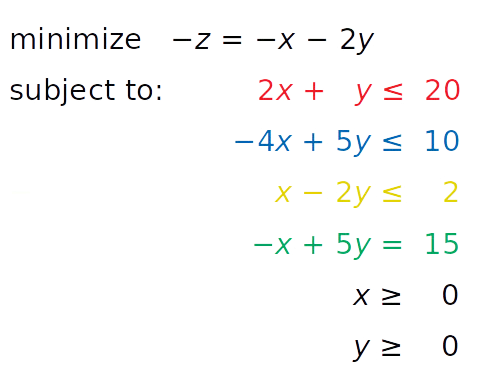

In [11]:
obj = [-1, -2]
#      ─┬  ─┬
#       │   └┤ Coefficient for y
#       └────┤ Coefficient for x

lhs_ineq = [[ 2,  1],  # Red constraint left side
            [-4,  5],  # Blue constraint left side
            [ 1, -2]]  # Yellow constraint left side

rhs_ineq = [20,  # Red constraint right side
            10,  # Blue constraint right side
             2]  # Yellow constraint right side

lhs_eq = [[-1, 5]]  # Green constraint left side
rhs_eq = [15]       # Green constraint right side

bnd = [(0, float("inf")),  # Bounds of x
       (0, float("inf"))]  # Bounds of y

opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
              method="revised simplex")

/tmp/ipykernel_10132/3265256019.py:20: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,


In [12]:
opt

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -16.818181818181817
       x: [ 7.727e+00  4.545e+00]
     nit: 3

In [13]:
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
from pulp import PULP_CBC_CMD

In [14]:
# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
x = LpVariable(name="x", lowBound=0)
y = LpVariable(name="y", lowBound=0)

# Add the constraints to the model
model += (2 * x + y <= 20, "red_constraint")
model += (4 * x - 5 * y >= -10, "blue_constraint")
model += (-x + 2 * y >= -2, "yellow_constraint")
model += (-x + 5 * y == 15, "green_constraint")

# Add the objective function to the model
# obj_func = x + 2 * y
# model += obj_func

model += lpSum([x, 2 * y])

In [15]:
model

small-problem:
MAXIMIZE
1*x + 2*y + 0.0
SUBJECT TO
red_constraint: 2 x + y <= 20

blue_constraint: 4 x - 5 y >= -10

yellow_constraint: - x + 2 y >= -2

green_constraint: - x + 5 y = 15

VARIABLES
x Continuous
y Continuous

In [16]:
# Solve the problem
status = model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hisanobu/.cache/pypoetry/virtualenvs/math-notes-rv-uysUR-py3.10/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/8601a0d4f85b49b9a193d978be61766a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/8601a0d4f85b49b9a193d978be61766a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 26 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-8) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 16.818182
After Postsolve, objective 16.818182, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 16.81818182 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to a

In [17]:
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")
for var in model.variables():
    print(f"{var.name}: {var.value()}")
    
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 16.8181817
x: 7.7272727
y: 4.5454545
red_constraint: -9.99999993922529e-08
blue_constraint: 18.181818300000003
yellow_constraint: 3.3636362999999996
green_constraint: -2.0000000233721948e-07


In [18]:
lpSum(model.variables()).value()

12.2727272

In [19]:
(1000 + 8000* x + 9000*y) >= 800*(1+x+y)

7200*x + 8200*y + 200 >= 0

In [20]:
var_list = [1, x, y]
lpSum([coef*v for coef, v in zip([1000, 8000, 9000], var_list)]) >= 800*lpSum(var_list)

7200*x + 8200*y + 200.0 >= 0

In [21]:
OrderedDict((k,v) for k, v in enumerate(["a", "b"]))

OrderedDict([(0, 'a'), (1, 'b')])

In [22]:
def get_upper_bound(mqis, index):
    if mqis['Fermented'].iloc[index]:
        return RecomendedValues['Amount Manure(kg)'].max
    return RecomendedValues['Amount Organic(kg)'].max

def calc_TX(TX_old, mqis, increases):
    numerator = (TX_old + increases * mqis)
    denominator = (1 + increases)

def prescribe(sofix,
              mqis,
              prefixed=[],
              name="sofix-prescription",
              pulp_msg=False,
              ):
    MQIs_trans = mqis.transpose()
    materials = MQIs_trans.columns.to_list()
    num_materials = len(materials)
#     kvs = [(materials[i], LpVariable(name=f"x{i+1}", 
#                      lowBound=0,
#                      upBound=get_upper_bound(mqis, i))) for i in range(num_materials)]
#     xs = OrderedDict(kvs)
    xs = OrderedDict()
    var_name2mat_name = {}
    for i in range(num_materials):
        mat_name = materials[i]
        var_name = f"x{i+1}"
        xs[mat_name] = LpVariable(name=var_name, 
                     lowBound=0,
                     upBound=get_upper_bound(mqis, i))
        var_name2mat_name[var_name] = mat_name
#     print(kvs)
    print(xs)
    sofix_selected = np.array([sofix[fld] for fld in selected_fields])
    print(f"{sofix_selected=}")
    constraints = []
    new_TXS = []
    for TXs in MQIs_trans.iterrows():
        target_element = TXs[0]
        if target_element not in selected_fields:
            continue
        mg_per_kgs = TXs[1]
#         print(f"{target_element=}")
        rng = RecomendedValues[target_element]
#         print(f"{rng=}")
        if rng.min:
            vars_ = list(xs.values())
#             print(f"{vars_=}")
            numerator = lpSum([sofix[target_element]]+[coef*x for coef, x in zip(mg_per_kgs, vars_)])
            denominator = lpSum([1] + vars_)
            constraint = numerator >= rng.min*denominator
            constraints.append(constraint)
            new_TXS.append((numerator, denominator))
#             print(constraint)
    
    obj_func = lpSum(xs)
    print(f"{obj_func=}")

    model = LpProblem(name=name, sense=LpMinimize)

    for cons in constraints:
        model += cons

    if prefixed:
        for i, (name, val) in enumerate(prefixed):
            model += (xs[name] == val, f"Prefixed Value{i}:{name}")
    model += obj_func

    model.solve(PULP_CBC_CMD(msg=False))

    print(f"status: {model.status}, {LpStatus[model.status]}")
    total_amount = model.objective.value()
    print(f"Objective(Total amount): {total_amount:.5f}[mg/kg]({round(total_amount*PERKG2PER10A)}[kg/10a])")
    for var in model.variables():
        print(f"{var_name2mat_name[var.name]}: {var.value():.5f}[mg/kg] ({round(var.value()*PERKG2PER10A)}[kg/10a])")
#     df = pd.DataFrame({name: [round(n.value()/d.value())] for name, (n, d) in zip(selected_fields, new_TXS)})
    new_TXs = [round(n.value()/d.value()) for name, (n, d) in zip(selected_fields, new_TXS)]
    display_fields = selected_fields + ["C/N", "C/P"]
    new_TXs = np.append(new_TXs, new_TXs[0]/new_TXs[1])
    new_TXs = np.append(new_TXs, new_TXs[0]/new_TXs[2])
    df = pd.DataFrame({k: [v] for k, v in zip(display_fields, new_TXs)})
    print(f"{df}")
#     for name, constraint in model.constraints.items():
#         print(f"{name}: {constraint.value()}")
        


In [29]:
prescribe(sofix=sofix1,
          mqis=MQIs.loc[['soy meal']],
         )

OrderedDict([('soy meal', x1)])
sofix_selected=array([11000,   800,   900,  2500])
obj_func=1*x1 + 0.0
status: -1, Infeasible
Objective(Total amount): 0.01835[mg/kg](4128[kg/10a])
soy meal: 0.01835[mg/kg] (4128[kg/10a])
        TC      TN      TP      TK       C/N        C/P
0  17288.0  1867.0  1100.0  2905.0  9.259775  15.716364


In [23]:
prescribe(sofix=sofix2,
          mqis=MQIs.loc[['cow manure', 'chicken manure', 'soy meal']],
         )

OrderedDict([('cow manure', x1), ('chicken manure', x2), ('soy meal', x3)])
sofix_selected=array([10000,   800,   900,  2500])
obj_func=1*x1 + 1*x2 + 1*x3 + 0.0
status: 1, Optimal
Objective(Total amount): 0.01183[mg/kg](2663[kg/10a])
cow manure: 0.00000[mg/kg] (0[kg/10a])
chicken manure: 0.01183[mg/kg] (2663[kg/10a])
soy meal: 0.00000[mg/kg] (0[kg/10a])
        TC      TN      TP      TK        C/N        C/P
0  12807.0  1142.0  1100.0  2798.0  11.214536  11.642727


In [24]:
prescribe(sofix=sofix4,
          mqis=MQIs.loc[['chicken manure', 'soy meal']],
         prefixed=[("chicken manure", 1000/PERKG2PER10A)])

OrderedDict([('chicken manure', x1), ('soy meal', x2)])
sofix_selected=array([25000,   800,  1100,  2500])
obj_func=1*x1 + 1*x2 + 0.0
status: 1, Optimal
Objective(Total amount): 0.00565[mg/kg](1271[kg/10a])
chicken manure: 0.00444[mg/kg] (1000[kg/10a])
soy meal: 0.00121[mg/kg] (271[kg/10a])
        TC      TN      TP      TK     C/N        C/P
0  26396.0  1000.0  1188.0  2640.0  26.396  22.218855


In [25]:
sofix5 = {"TC": 25000, "TN": 700, "TP": 1100, "TK": 2500, "C/N": 35.7}
prescribe(sofix=sofix5,
          mqis=MQIs.loc[['chicken manure', 'soy meal']],
         prefixed=[("chicken manure", 1500/PERKG2PER10A)])

OrderedDict([('chicken manure', x1), ('soy meal', x2)])
sofix_selected=array([25000,   700,  1100,  2500])
obj_func=1*x1 + 1*x2 + 0.0
status: 1, Optimal
Objective(Total amount): 0.00847[mg/kg](1907[kg/10a])
chicken manure: 0.00667[mg/kg] (1500[kg/10a])
soy meal: 0.00181[mg/kg] (407[kg/10a])
        TC      TN      TP      TK     C/N        C/P
0  27088.0  1000.0  1231.0  2709.0  27.088  22.004874


In [26]:
25000/800

31.25

In [27]:
sofix5 = {"TC": 25000, "TN": 1000, "TP": 800, "TK": 2500, "C/N": 25.0, "C/P":31.3}
prescribe(sofix=sofix5,
          mqis=MQIs.loc[['rice bran', 'fish bone', 'bone']])

OrderedDict([('rice bran', x1), ('fish bone', x2), ('bone', x3)])
sofix_selected=array([25000,  1000,   800,  2500])
obj_func=1*x1 + 1*x2 + 1*x3 + 0.0
status: 1, Optimal
Objective(Total amount): 0.00358[mg/kg](806[kg/10a])
rice bran: 0.00000[mg/kg] (0[kg/10a])
fish bone: 0.00136[mg/kg] (306[kg/10a])
bone: 0.00222[mg/kg] (500[kg/10a])
        TC      TN      TP      TK        C/N        C/P
0  25810.0  1202.0  1100.0  2508.0  21.472546  23.463636


In [32]:
sofix = {"TC": 15000, "TN": 800, "TP": 1100, "TK": 2500, "C/N": 18.8}
prescribe(sofix=sofix,
          mqis=MQIs.loc[['soy meal']],
         )

OrderedDict([('soy meal', x1)])
sofix_selected=array([15000,   800,  1100,  2500])
obj_func=1*x1 + 0.0
status: -1, Infeasible
Objective(Total amount): 0.00339[mg/kg](763[kg/10a])
soy meal: 0.00339[mg/kg] (763[kg/10a])
        TC      TN      TP      TK     C/N        C/P
0  16166.0  1000.0  1137.0  2576.0  16.166  14.218118


In [40]:
sofix = {"TC": 10000, "TN": 800, "TP": 900, "TK": 2500, "C/N": 12.5}
print(f"{[(k, v/RecomendedValues[k].min) for k, v in sofix.items()]}")
prescribe(sofix=sofix,
          mqis=MQIs.loc[['cow manure']],
         )
print("")
prescribe(sofix=sofix,
          mqis=MQIs.loc[['cow manure', 'chicken manure', 'soy meal']],
         )

[('TC', 0.8333333333333334), ('TN', 0.8), ('TP', 0.8181818181818182), ('TK', 1.0), ('C/N', 1.5625)]
OrderedDict([('cow manure', x1)])
sofix_selected=array([10000,   800,   900,  2500])
obj_func=1*x1 + 0.0
status: -1, Infeasible
Objective(Total amount): 0.02899[mg/kg](6522[kg/10a])
cow manure: 0.02899[mg/kg] (6522[kg/10a])
        TC      TN      TP      TK        C/N        C/P
0  18732.0  1285.0  1100.0  3021.0  14.577432  17.029091

OrderedDict([('cow manure', x1), ('chicken manure', x2), ('soy meal', x3)])
sofix_selected=array([10000,   800,   900,  2500])
obj_func=1*x1 + 1*x2 + 1*x3 + 0.0
status: 1, Optimal
Objective(Total amount): 0.01183[mg/kg](2663[kg/10a])
cow manure: 0.00000[mg/kg] (0[kg/10a])
chicken manure: 0.01183[mg/kg] (2663[kg/10a])
soy meal: 0.00000[mg/kg] (0[kg/10a])
        TC      TN      TP      TK        C/N        C/P
0  12807.0  1142.0  1100.0  2798.0  11.214536  11.642727


In [70]:
MQIs

,TC,TN,TP,TK,C/N,C/P,Fermented
cow manure,320000,18000,8000,21000,17.8,40.0,True
chicken manure,250000,30000,18000,28000,8.3,13.9,True
soy meal,360000,60000,12000,25000,6.0,30.0,False
rice bran,350000,20000,35000,20000,17.5,10.0,False
fish bone,320000,70000,60000,10000,4.6,5.3,False
bone,210000,50000,100000,1500,4.2,2.1,False
